In [1]:
!pip install pyspark py4j

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg
from pyspark.context import SparkContext

from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
spark = SparkSession.builder.getOrCreate()
spark.stop()

In [4]:
spark = SparkSession.builder.config("spark.driver.memory", "16g").getOrCreate()

In [5]:
df = spark.read.csv("diabetes.csv", header = True, inferSchema = True)
df.show(10)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [6]:
print(df.columns)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [7]:
colnames = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"] + \
           ["DiabetesPedigreeFunction","Age", "Outcome"]


In [8]:
print(colnames)

print(df.printSchema())

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)

None


In [9]:
from pyspark.sql.types import DoubleType

In [10]:
data = df.toDF(*colnames).withColumn("Outcome", col("Outcome").cast(DoubleType()))

In [11]:
print(data.printSchema())

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: double (nullable = true)

None


In [12]:
print(data.summary)

<bound method DataFrame.summary of DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, DiabetesPedigreeFunction: double, Age: int, Outcome: double]>


In [13]:
traindata, testdata = data.randomSplit([0.9, 0.1])

In [14]:
from pyspark.ml.feature import VectorAssembler

vectorassembler = VectorAssembler(inputCols = colnames[:-1], outputCol = "featureVector")
traindata = vectorassembler.transform(traindata)

traindata.select("featureVector").show()


+--------------------+
|       featureVector|
+--------------------+
|[0.0,57.0,60.0,0....|
|[0.0,67.0,76.0,0....|
|(8,[1,5,6,7],[73....|
|[0.0,74.0,52.0,10...|
|[0.0,78.0,88.0,29...|
|[0.0,84.0,64.0,22...|
|[0.0,84.0,82.0,31...|
|[0.0,86.0,68.0,32...|
|[0.0,91.0,68.0,32...|
|[0.0,91.0,80.0,0....|
|[0.0,93.0,60.0,0....|
|[0.0,93.0,100.0,3...|
|(8,[1,6,7],[94.0,...|
|[0.0,94.0,70.0,27...|
|[0.0,95.0,64.0,39...|
|[0.0,95.0,80.0,45...|
|[0.0,95.0,85.0,25...|
|[0.0,97.0,64.0,36...|
|[0.0,98.0,82.0,15...|
|(8,[1,5,6,7],[99....|
+--------------------+
only showing top 20 rows



In [15]:
from pyspark.ml.classification import DecisionTreeClassifier

classifier = DecisionTreeClassifier(seed = 1234, labelCol = "Outcome", featuresCol = "featureVector", predictionCol = "prediction")
model = classifier.fit(traindata)

In [16]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_41e3c06ebc7e, depth=5, numNodes=49, numClasses=2, numFeatures=8
  If (feature 1 <= 141.5)
   If (feature 7 <= 28.5)
    If (feature 1 <= 127.5)
     If (feature 5 <= 30.75)
      If (feature 0 <= 7.5)
       Predict: 0.0
      Else (feature 0 > 7.5)
       Predict: 1.0
     Else (feature 5 > 30.75)
      Predict: 0.0
    Else (feature 1 > 127.5)
     If (feature 2 <= 57.0)
      If (feature 3 <= 3.5)
       Predict: 1.0
      Else (feature 3 > 3.5)
       Predict: 0.0
     Else (feature 2 > 57.0)
      If (feature 5 <= 42.150000000000006)
       Predict: 0.0
      Else (feature 5 > 42.150000000000006)
       Predict: 1.0
   Else (feature 7 > 28.5)
    If (feature 5 <= 26.25)
     If (feature 5 <= 20.05)
      If (feature 0 <= 6.5)
       Predict: 0.0
      Else (feature 0 > 6.5)
       Predict: 1.0
     Else (feature 5 > 20.05)
      Predict: 0.0
    Else (feature 5 > 26.25)
     If (feature 1 <= 107.5)
      If (feature 4 <= 

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(traindata)
evaluator=MulticlassClassificationEvaluator(labelCol="Outcome",predictionCol="prediction")

In [33]:
acc = evaluator.setMetricName("accuracy").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)

In [19]:
print(f1)
print(acc)

0.8327767798945498
0.8371428571428572


In [37]:
from pyspark.mllib.evaluation import MulticlassMetrics


# Extracting true labels and predicted labels
true_labels = predictions.select("Outcome").rdd.map(lambda x: x[0])
predicted_labels = predictions.select("prediction").rdd.map(lambda x: x[0])

# Combine true labels and predicted labels into a RDD of label pairs
predictionAndLabels = predicted_labels.zip(true_labels)

# Instantiate MulticlassMetrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate recall for each class
recall_per_class = metrics.recall(1)

# Print recall for each class
print("Recall per class:", recall_per_class)

Recall per class: 0.6748971193415638


In [49]:
# Calculate the correlation matrix
correlation_matrix = predictions.corr("Outcome", "prediction")
print(f"correlation between the output and the predicted values: {correlation_matrix}")

correlation between the output and the predicted values: 0.6314552745855844


In [20]:
predictions.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+-------------+--------------------+----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|       featureVector|rawPrediction|         probability|prediction|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+-------------+--------------------+----------+
|          0|     57|           60|            0|      0|21.7|                   0.735| 67|    0.0|[0.0,57.0,60.0,0....|   [37.0,1.0]|[0.97368421052631...|       0.0|
|          0|     67|           76|            0|      0|45.3|                   0.194| 46|    0.0|[0.0,67.0,76.0,0....|  [56.0,17.0]|[0.76712328767123...|       0.0|
|          0|     73|            0|            0|      0|21.1|                   0.342| 25|    0.0|(8,[1,5,6,7],[73....|  [134.0,1.0]|[0.99259259259259...|       0.0

In [21]:
testdata.drop("featureVector")

DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, DiabetesPedigreeFunction: double, Age: int, Outcome: double]

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

testdata = vectorassembler.transform(testdata)
tpredictions = model.transform(testdata)
evaluator=MulticlassClassificationEvaluator(labelCol="Outcome",predictionCol="prediction")
acc = evaluator.setMetricName("accuracy").evaluate(tpredictions)
f1 = evaluator.setMetricName("f1").evaluate(tpredictions)
print(f1)
print(acc)

0.7031563845050215
0.7205882352941176


In [23]:
predictions.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+-------------+--------------------+----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|       featureVector|rawPrediction|         probability|prediction|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+-------------+--------------------+----------+
|          0|     57|           60|            0|      0|21.7|                   0.735| 67|    0.0|[0.0,57.0,60.0,0....|   [37.0,1.0]|[0.97368421052631...|       0.0|
|          0|     67|           76|            0|      0|45.3|                   0.194| 46|    0.0|[0.0,67.0,76.0,0....|  [56.0,17.0]|[0.76712328767123...|       0.0|
|          0|     73|            0|            0|      0|21.1|                   0.342| 25|    0.0|(8,[1,5,6,7],[73....|  [134.0,1.0]|[0.99259259259259...|       0.0

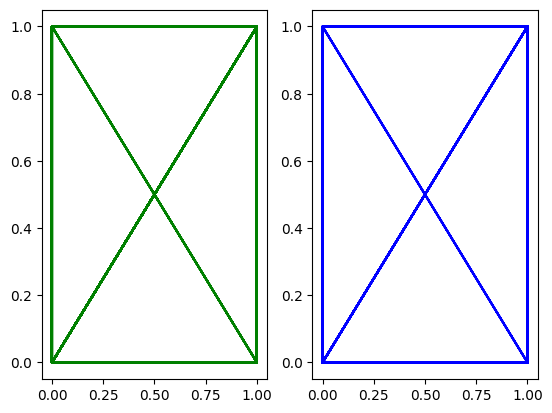

In [31]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axs = plt.subplots(1, 2)  # 1 rows, 2 columns

# Plot data on the first subplot (top-left)
axs[0].plot(predictions.select("Outcome").collect(), predictions.select("prediction").collect(), color='green')

# Plot data on the second subplot (top-right)
axs[1].plot(tpredictions.select("Outcome").collect(), tpredictions.select("prediction").collect(), color='blue')

# The TypeError "Column object is not callable" occurs because you're trying to call a Column object as if it were a function. In PySpark, when you use select() method on a DataFrame, it returns a Column object, not a DataFrame.
# To fix the error, you need to extract the values from the Column objects before plotting them. You can use the collect() method to collect the values into a list or array. Here's how you can modify your code: